In this notebook, we attempt to develop Deep Q-Networks for agents to learn Atari games, including the famous Breakout. OpenAI Gym's environment rendering provides individual frames which are preprocessed and fed to a state-action network to learn optimal behaviour. Epsilon-Greedy exploration is used where epsilon is gradually adjusted over time. We attempt to reproduce DeepMind's 2013 paper in terms of neural network architecture to teach the agent. In accordance with the paper, we repeat each chosen action for k frames (k=4), and hence each action decision involves accessing four consecutive frames in a convolutional net. Grayscaling and downsampling preprocessing is performed.

In [13]:
import gym
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import collections
import itertools
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Input, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from copy import deepcopy

<h2> SECTION 1: Preprocessing and Model Architecture

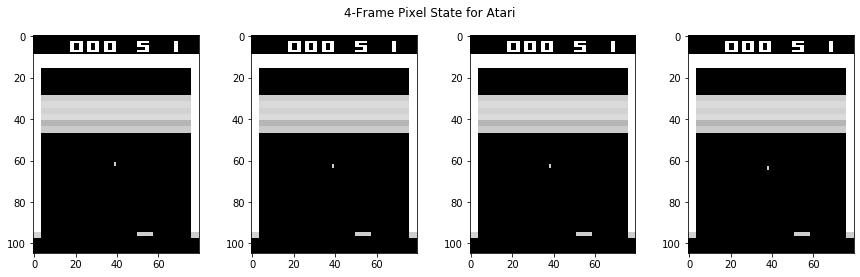

In [2]:
def preprocessing(framelist):
    frames = np.zeros((np.int(framelist[0].shape[0]/2), np.int(framelist[0].shape[1]/2), 4), dtype=np.float64)
    for i in range(4):
        frames[:,:,i] = np.mean(framelist[i], axis=2)[::2,::2]
    return frames
#Example State Fed to Network
env = gym.make("BreakoutNoFrameskip-v4")
frame = env.reset()
framelist = collections.deque()
actions = [1,2,3,2]
for i in range(4):
    frame, reward, is_done, _ = env.step(actions[i])
    framelist.append(frame)
frames = preprocessing(framelist)
plt.figure(figsize=(15,4))
plt.suptitle("4-Frame Pixel State for Atari")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(frames[:,:,i], cmap="gray")
plt.show()

In [3]:
def build_model(env, imgheight, imgwidth):
    tf.keras.backend.clear_session()
    mask = Input((len(env.unwrapped.get_action_meanings()),))
    frameinp = Input((imgheight, imgwidth, 4))
    conv1 = Conv2D(filters=16, kernel_size=(8,8), strides=4, padding="valid")(frameinp)
    activ1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)
    conv2 = Conv2D(filters=32, kernel_size=(4,4), strides=2, padding="valid", activation="relu")(activ1)
    preproc = Dropout(0.05)(Flatten()(conv2))
    dense = Dense(units=256, activation="relu")(preproc)
    rawoutput = Dense(units=len(env.unwrapped.get_action_meanings()), activation=None)(dense)
    finaloutput = Lambda(lambda tensors: tf.math.multiply(tensors[0], tensors[1]))([rawoutput, mask])
    mdl = Model(inputs=[mask, frameinp], outputs=finaloutput)
    mdl.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3))
    return mdl
build_model(env, 110, 84).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 110, 84, 4)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 20, 16)   4112        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 26, 20, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 9, 32)    8224        leaky_re_lu[0][0]                
______________________________________________________________________________________________

<h2>SECTION 2: Experience Replay</h2>

In [9]:
class ExperienceReplay():
    def __init__(self, buffersize, batchsize):
        self.buffersize, self.batchsize = buffersize, batchsize
        self.sars = collections.deque()
        self.cursize = 0
    def add(self, state1, action, reward, state2):
        while self.cursize>=self.buffersize:
            self.sars.popleft()
            self.cursize-=1
        self.sars.append((state1, action, reward, state2))
        self.cursize+=1
    def sample(self, env):
        if self.cursize==0: return
        replacer = True if self.cursize<self.batchsize else False
        indices = np.random.choice(self.cursize, self.batchsize, replace=replacer)
        state1 = np.zeros((self.batchsize, self.sars[0][0].shape[0], 
                           self.sars[0][0].shape[1], self.sars[0][0].shape[2]))
        reward = np.zeros(self.batchsize)
        action = np.zeros((self.batchsize, len(env.unwrapped.get_action_meanings())))
        state2 = np.zeros((self.batchsize, self.sars[0][0].shape[0], 
                           self.sars[0][0].shape[1], self.sars[0][0].shape[2]))
        for i in range(len(indices)):
            data = self.sars[indices[i]]
            state1[i], reward[i], state2[i] = data[0], data[2], data[3]
            action[i,data[1]] = 1
        return state1, action, reward, state2   

<h2>SECTION 3: Episodic Training </h2>

In [ ]:
def epsilon_greedy_action(state, env):
    actionvalues = model.predict([np.ones((1,len(env.unwrapped.get_action_meanings()))), np.array([state])])
    maxval = np.max(actionvalues)
    bestactions = collections.deque()
    for i in range(len(actionvalues)):
        if actionvalues[i]==maxval:
            bestactions.append(i)
    prob, action = np.random.uniform(), None
    if prob<(1-epsilon):
        action = np.random.choice(bestactions)
    else:
        action = np.random.choice(len(actionvalues))

In [ ]:
def one_episode(model, env, epsilon):
    frame = env.reset()
    state1 = preprocessing([deepcopy(frame) for _ in range(4)])
    is_done = False
    while not is_done:
        
        
        
    
    